In [3]:
%matplotlib inline   

# load the libraries
import matplotlib.pyplot as plt # 2D plotting library
import numpy as np              # package for scientific computing  

import math              # package for mathematics (pi, arctan, sqrt, factorial ...)

import cmath 
from sympy import symbols, I, exp, diff, lambdify
from mpl_toolkits.mplot3d import Axes3D  # Not used directly, but required for 3D plots
from matplotlib import cm

# Impedance 

In [4]:
def G_new(p, q, k, z, z_1, L_1, L_2, L_3):
   
    """

    Parameters
    ----------
    p, q: antenna indexes
    k : wavenumber
    z : 
    z_1 : z'
    L_1, L_2, L_3: list of antennas characteristic (ordered in the same order as the antennas in the linear array)
    Returns so called impedance kernel=Green function, used to compute the impedance coefficients
    -------
    """

    #print(L_2)
    if p == q:
        d = L_2[p]
    else:
        d = math.sqrt((L_3[p][0] - L_3[q][0])**2+ (L_3[p][1] - L_3[q][1])**2)
    #print(d)
    R = math.sqrt((z - z_1)**2 + d**2)
    if R < 1e-6:  # threshold for small distances
        return 0 
    #print(R)
    return (cmath.exp(-k * R*1j))/R


def Z_new(p, q, k, L_1, L_2, L_3):
    """
    Compute the coefficient of entry (p, q) of the impedance matrix (after integration by part). 
    In fact, no need to put k as argument.
    Note: The same formula can be retrieved with the near-field expression
    p, q: index of coeff Zpq in the impedance matrix

    """
    
    h_p = L_1[p]/2
    h_q = L_1[q]/2
    if p == q:
        N = 500 
    else:
        N = 300
    Z = 0
    eta = 376.7 #sqrt(mu_0/epsilon_0)
    
    for n in range(-N//2, N//2+1):
        z_1 = (n*2*h_q)/N
        dz_1 = 2*h_q/N
        g1 = G_new(p, q, k, h_p, z_1, L_1, L_2, L_3)
        g2 = G_new(p, q, k, -h_p, z_1, L_1, L_2, L_3)
        g3 = G_new(p, q, k, 0, z_1, L_1, L_2, L_3)
        sinq = math.sin(k*(h_q- abs(z_1)))
        Z += sinq*(g1+g2-2*np.cos(k*h_p)*g3)*dz_1
    Z = Z*(complex(0, eta/(4*math.pi)))*1/(np.sin(k*h_p)*np.sin(k*h_q))          
    return Z  

In [5]:
def matrixZ_new(k, L_1, L_2, L_3):
    """
    Compute the impedance matrix Z for antenna arrays. Optimized by using the symmetry of Z.
    
    """
    n = len(L_1) #nb of antennas
    #matZ = np.matrix([[Z(p,q,k) for q in range(0,n)] for p in range(0,n)])
    matZ= np.zeros((n, n), dtype=complex)
    for p in range(0, n):
        for q in range(0, p+1):
            Z_pq =  Z_new(p,q,k, L_1, L_2, L_3)
            if p == q:
                matZ[p][q] = Z_pq
            else:
                matZ[p][q] = Z_pq
                matZ[q][p] = Z_pq
    return matZ

In [6]:
def input_current(V,Z):
    """
    Solve the matrix equation ZI = V, given the input voltage in each antenna and the impedance matrix.
    V: list of input voltage. Index corresponds to the antenna number in the array.
    Z: matrix with coeff obtained with matrixZ_new(k)
    """
    I = np.linalg.solve(Z, V)
    return I  

# Radiation Intensity U

In [7]:
def radiation_intensity(k, theta, phi, lengths, spacings):
    """
    Radiation intensity for the SPECIFIC case of antenna arrays along x-axis, which needs to be refined for other types.
    k: wavenumber of the emitted wave
    theta, phi: spherical coordinates
    Issue solved at theta = 0, theta = pi
    """
    def identify_vector_arg(theta, phi):
        if np.ndim(theta) > 0 and np.ndim(phi) > 0:
            vector_arg = np.zeros(np.shape(theta))  # or np.broadcast(theta, phi)[0]
        elif np.ndim(theta) > 0:
            vector_arg = theta
        else:
            vector_arg = phi
        return vector_arg

   
    wavelength = 2*math.pi/k
    n = len(lengths)
    L_1 = [l*wavelength for l in lengths]
    L_2 = [0.001*wavelength for _ in range(n)]
    L_3 = [(x*wavelength, y*wavelength, z*wavelength) for (x, y, z) in spacings] #L_3 = [(sum(spacings[:i])*wavelength, 0) for i in range(n)]
    
    eta = 376.7 #sqrt(mu_0/epsilon_0)
    V = [0, 0, 0, 0, 0, 1]+[0]*(n-6) #[0, 1]+[0]*(n-2)
    I = input_current(V,matrixZ_new(k, L_1, L_2, L_3))
    M = identify_vector_arg(theta, phi)
    
    U = np.zeros_like(M, dtype=complex)  # to accumulate field
    for p in range(0, len(L_1)):
        h_p = L_1[p]/2
        term1 = np.exp(1j*k*np.sin(theta)*(L_3[p][0]*np.cos(phi)+L_3[p][1]*np.sin(phi)))
        if np.ndim(theta) > 0:
            mask = (theta != 0) & (theta != np.pi) #to deal with division by 0 at theta = 0 and theta = pi: extension to 0 by continuity
            term2 = np.zeros_like(theta, dtype=complex)
            term2[mask] = (np.cos(k*h_p*np.cos(theta[mask]))-np.cos(k*h_p))/(np.sin(k*h_p)*np.sin(theta[mask]))
        else:
            term2 =  (np.cos(k*h_p*np.cos(theta))-np.cos(k*h_p))/(np.sin(k*h_p)*np.sin(theta))
        U += I[p]*term1*term2
    return (eta/(8*np.pi**2))*abs(U)**2


def radiated_power(k, lengths, spacings):
    theta = np.linspace(0, np.pi, 200)
    phi = np.linspace(0, 2 * np.pi, 200)
    dtheta = theta[1] - theta[0]
    dphi = phi[1] - phi[0]
    
    THETA, PHI = np.meshgrid(theta, phi, indexing='ij')
    U = radiation_intensity(k, THETA, PHI, lengths, spacings)
    
    integrand = U * np.sin(THETA)
    P_rad = np.sum(integrand) * dtheta * dphi
    return P_rad

In [8]:
def directivity(k, theta, phi, lengths, spacings):


    # Compute radiation intensity U(θ, φ)
    U = radiation_intensity(k, theta, phi, lengths, spacings)  # shape (len(theta), len(phi))
    #print("U shape:", U.shape)
    P = radiated_power(k, lengths, spacings)
    
    
    # Directivity
    D = 4 * np.pi * U / P
    if np.any(D < 0):
        raise ValueError("Directivity contains negative values. Check radiation intensity calculation.")
    #A negative dB simply means the directivity is less than 1 
    #(i.e., it's radiating less intensely in the peak direction than an isotropic radiator would).
    #In the case of Yagi, it should not happen along positive x.
    return D

In [9]:
def max_directivity(k, lengths, spacings):
    phi = np.linspace(0, 2 * np.pi, 500)
    theta = np.linspace(0, np.pi, 500)

    # Create meshgrid
    THETA, PHI = np.meshgrid(theta, phi, indexing='ij')
    D = directivity(k, THETA, PHI, lengths, spacings)
    D_max = np.max(D)
    max_index = np.unravel_index(np.argmax(D), D.shape)
    
    max_theta = THETA[max_index]
    max_phi = PHI[max_index]
    return f'The maximum directivity is {D_max} for theta, phi = {max_theta}, {max_phi}'

# Polytechnique Antenna

In [10]:
def directors(positions, lengths, n, d, l):
    """
    n: number of director desired
    positions, lengths: list of reflectors and driven element positions and lengths to be updated
    d : distance between directors
    l : difference of length between directors
    """
    x = positions[-1][0]
    pos = positions + [(x+i*d, 0, 0) for i in range(n)]
    leng = lengths + [lengths[-1]-0.04-i*l for i in range(n)]
    return pos, leng

In [11]:
def plot_vertical_lines(positions, lengths, l=1, color='b'):
    """
    positions: list of (x, y, z) tuples
    l: length of vertical line (along z)
    color: line color
    returns the structure of the array
    """
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    for i in range(len(lengths)):
        x = positions[i][0]
        y = positions[i][1]
        z = positions[i][2]
        l = lengths[i]
        ax.plot([x, x], [y, y], [z - l/2, z + l/2], color=color)
    ax.view_init(elev=30, azim=50)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Array shape')
    ax.grid(True)
    plt.tight_layout()
    
    plt.show()

In [12]:
def plot_3D_yagi(k, positions, lengths):
    # Finer grid for better resolution
    theta = np.linspace(0, np.pi, 360)     # Elevation angle
    phi = np.linspace(0, 2 * np.pi, 360)   # Azimuth angle
    theta_grid, phi_grid = np.meshgrid(theta, phi)

    # Calculate the gain
    U = radiation_intensity(k, theta_grid, phi_grid, lengths, positions)

    # Normalize gain
    U = U / np.max(U)

    #Slightly exaggerate gain visually to make thin lobes more visible, as they are not on the other 3D plot version
    g_plot = U ** 0.7  # gamma correction: <1 exaggerates lobes

    # Convert spherical to Cartesian
    X = g_plot * np.sin(theta_grid) * np.cos(phi_grid)
    Y = g_plot * np.sin(theta_grid) * np.sin(phi_grid)
    Z = g_plot * np.cos(theta_grid)

    # Plotting
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    norm = plt.Normalize(vmin=0, vmax=1)
    colors = plt.cm.viridis(norm(U))

    surf = ax.plot_surface(X, Y, Z, facecolors=colors, rstride=1, cstride=1,
                           antialiased=True, linewidth=0, shade=True)

    # Equal aspect ratio
    def set_axes_equal(ax):
        limits = np.array([
            ax.get_xlim3d(),
            ax.get_ylim3d(),
            ax.get_zlim3d(),
        ])
        centers = np.mean(limits, axis=1)
        radius = 0.5 * np.max(np.abs(limits[:, 1] - limits[:, 0]))
        ax.set_xlim3d([centers[0] - radius, centers[0] + radius])
        ax.set_ylim3d([centers[1] - radius, centers[1] + radius])
        ax.set_zlim3d([centers[2] - radius, centers[2] + radius])

    set_axes_equal(ax)

    # View angle
    ax.view_init(elev=30, azim=50)

    # Colorbar
    mappable = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=norm)
    mappable.set_array(U)
    fig.colorbar(mappable, shrink=0.6, label='Normalized Gain')

    # Labels and aesthetics
    ax.set_title('Normalized Radiation Pattern (3D)')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.tight_layout()
    plt.show()

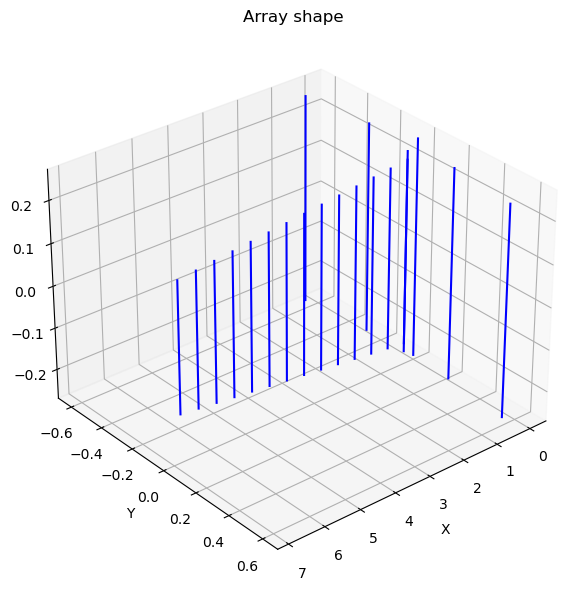

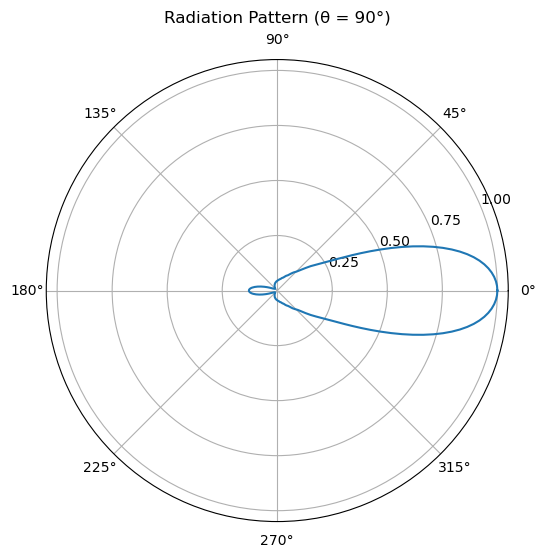

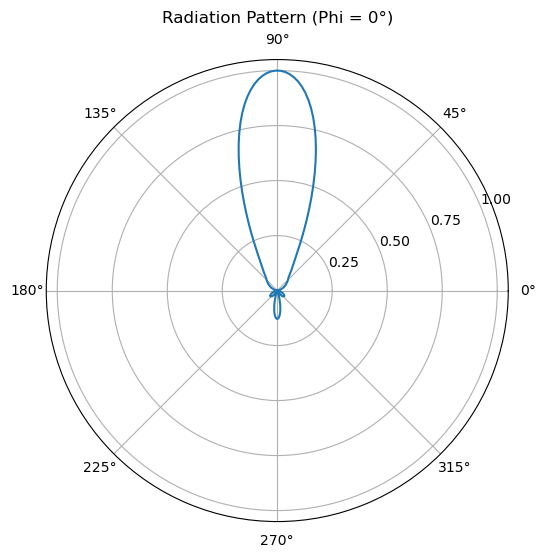

C:\Users\mattc\AppData\Local\Temp\ipykernel_27480\3200691243.py:52: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(mappable, shrink=0.6, label='Normalized Gain')


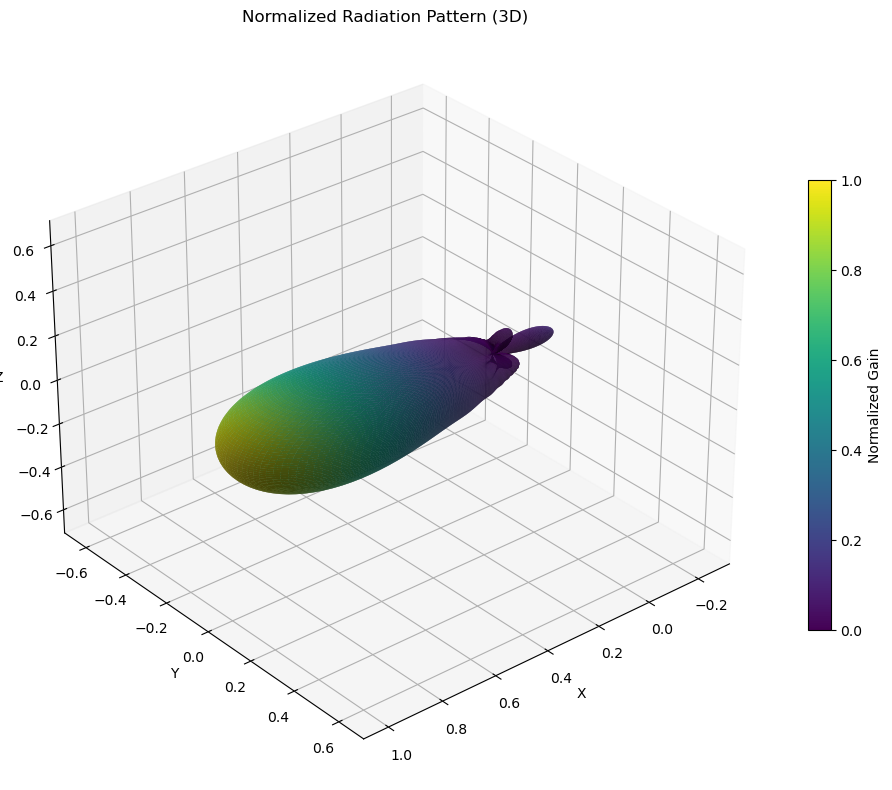

In [13]:
"""positions = [
    (0.00,  0.0, 0.0),   # Horizontal reflector
    (0.20,  0.3, 0.0),   # Vertical reflector above
    (0.20, -0.3, 0.0),   # Vertical reflector below
    (0.25,  0.0, 0.0),   # Driven element
    (0.45,  0.0, 0.0),   # Director 1
    (0.65,  0.0, 0.0),   # Director 2
    (0.85,  0.0, 0.0),   # Director 3
    (1.05,  0.0, 0.0),   # Director 4
    (1.25,  0.0, 0.0),   # Director 5
    (1.45,  0.0, 0.0),   # Director 6
    (1.65,  0.0, 0.0),   # Director 7
]
lengths = [
    0.52,  # Horizontal reflector
    0.50,  # Vertical reflector above
    0.50,  # Vertical reflector below
    0.48,  # Driven element
    0.44,  # Director 1
    0.43,  # Director 2
    0.42,  # Director 3
    0.41,  # Director 4
    0.40,  # Director 5
    0.39,  # Director 6
    0.38,  # Director 7
]
"""
positions, lengths = directors([
    (0.0,  0.0, 0.0),   
    (0.2,  0.25, 0.0),   
    (0.2, -0.25, 0.0),   
    (0.4,  0.6, 0.0),  
    (0.4, -0.6, 0.0),   
    (0.3,  0.0, 0.0)], [0.52, 0.50, 0.50, 0.50, 0.50, 0.48],14, 0.5, 0.01)
theta = np.pi/2
phi = np.linspace(0, 2*np.pi, 300)
k = 1

U = radiation_intensity(k, theta, phi, lengths, positions)
# Normalize
U /= np.max(U)

# Polar plot
plot_vertical_lines(positions, lengths, l=1.0, color='b')
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, projection='polar')
ax.plot(phi, U)
ax.set_title("Radiation Pattern (θ = 90°)", va='bottom')
ax.set_rticks([0.25, 0.5, 0.75, 1.0])
plt.show()


theta = np.linspace(0, 2*np.pi, 300)
phi = 0
k = 1

U1 = radiation_intensity(k, theta, phi, lengths, positions)
# Normalize
U1 /= np.max(U1)

# Polar plot
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, projection='polar')
ax.plot(theta, U1)
ax.set_title("Radiation Pattern (Phi = 0°)", va='bottom')
ax.set_rticks([0.25, 0.5, 0.75, 1.0])
plt.show()

plot_3D_yagi(k, positions, lengths)

# Optimization

In [40]:
def optimize_yagi_antenna(n_elements=5, population_size=100, generations=50):
    """
    Optimise une antenne Yagi en utilisant un algorithme génétique.
    
    Args:
        n_elements: Nombre d'éléments dans l'antenne Yagi
        population_size: Taille de la population
        generations: Nombre de générations
        
    Returns:
        Tuple contenant (meilleures longueurs, meilleurs espacements, directivité maximale)
    """
    import random
    import numpy as np
    import time
    import matplotlib.pyplot as plt
    
    # Configuration pour l'optimisation
    # Bornes typiques pour les antennes Yagi (en longueurs d'onde)
    LENGTH_MIN, LENGTH_MAX = 0.40, 0.65  # Longueurs typiques
    REFLECTOR_MIN, REFLECTOR_MAX = 0.55, 0.65  # Réflecteur toujours plus long que le dipôle
    DIPOLE_MIN, DIPOLE_MAX = 0.45, 0.52  # Dipôle autour de 0.5λ
    DIRECTOR_MIN, DIRECTOR_MAX = 0.40, 0.48  # Directeurs généralement plus courts
    SPACING_MIN, SPACING_MAX = 0.15, 0.40  # Espacements typiques
    
    # Nombre total de paramètres: n_elements longueurs + (n_elements-1) espacements
    n_params = 2 * n_elements - 1
    
    # Création d'un individu aléatoire avec des contraintes spécifiques
    def create_individual():
        individual = []
        
        # Longueurs des éléments
        reflector_length = random.uniform(REFLECTOR_MIN, REFLECTOR_MAX)  # Réflecteur
        dipole_length = random.uniform(DIPOLE_MIN, min(DIPOLE_MAX, reflector_length - 0.03))  # Dipôle toujours plus court que le réflecteur
        
        individual.append(reflector_length)
        individual.append(dipole_length)
        
        # Directeurs (de plus en plus courts)
        prev_length = dipole_length
        for i in range(2, n_elements):
            # Chaque directeur est plus court que l'élément précédent
            director_length = random.uniform(DIRECTOR_MIN, min(DIRECTOR_MAX, prev_length - 0.01))
            individual.append(director_length)
            prev_length = director_length
        
        # Espacements entre les éléments
        for i in range(n_elements - 1):
            individual.append(random.uniform(SPACING_MIN, SPACING_MAX))
            
        return individual
    
    # Création de la population initiale
    population = [create_individual() for _ in range(population_size)]
    
    # Fonction d'évaluation
    def evaluate(individual):
        lengths = individual[:n_elements]
        spacings = individual[n_elements:]

        k = 2 * np.pi

        # Utiliser une résolution plus basse pendant l'optimisation
        phi = np.array([0])  # Direction de l'axe principal
        theta = np.linspace(15*np.pi/32, 17*np.pi/32, 36)  # Autour du plan H

        try:
            D = directivity(k, theta, phi, lengths, spacings)
            D_max = np.max(D)

            if not np.isfinite(D_max) or D_max <= 0:
                return 0.0

            return D_max
        except Exception as e:
            print(f"Erreur lors de l'évaluation: {e}")
            return 0.0
    
    # Sélection par tournoi
    def tournament_selection(population, fitnesses, tournament_size=3):
        selected = []
        for _ in range(len(population)):
            # Sélection aléatoire des participants au tournoi
            aspirants_idx = random.sample(range(len(population)), tournament_size)
            # Le gagnant est celui avec la meilleure fitness
            winner_idx = max(aspirants_idx, key=lambda i: fitnesses[i])
            selected.append(population[winner_idx].copy())
        return selected
    
    # Croisement mixte (blend crossover)
    def blend_crossover(parent1, parent2, alpha=0.5):
        child1 = []
        child2 = []
        
        for gene1, gene2 in zip(parent1, parent2):
            # Déterminer les bornes du mélange
            lower = min(gene1, gene2) - alpha * abs(gene2 - gene1)
            upper = max(gene1, gene2) + alpha * abs(gene2 - gene1)
            
            # Générer les nouvelles valeurs
            value1 = random.uniform(lower, upper)
            value2 = random.uniform(lower, upper)
            
            child1.append(value1)
            child2.append(value2)
        
        # Assurer que les contraintes physiques sont respectées après le croisement
        # Réflecteur > Dipôle > Directeurs
        for i in range(n_elements - 1):
            if child1[i] <= child1[i+1]:  # Si élément i n'est pas plus long que i+1
                # Ajuster les longueurs pour respecter la contrainte
                avg = (child1[i] + child1[i+1]) / 2
                child1[i] = avg + 0.02  # Élément i légèrement plus long
                child1[i+1] = avg - 0.02  # Élément i+1 légèrement plus court
                
            if child2[i] <= child2[i+1]:
                avg = (child2[i] + child2[i+1]) / 2
                child2[i] = avg + 0.02
                child2[i+1] = avg - 0.02
        
        return child1, child2
    
    # Mutation gaussienne
    def gaussian_mutation(individual, mu=0, sigma=0.05, prob=0.2):
        for i in range(len(individual)):
            if random.random() < prob:
                individual[i] += random.gauss(mu, sigma)
                
                # Appliquer des limites spécifiques selon le type de paramètre
                if i < n_elements:  # Si c'est une longueur
                    if i == 0:  # Réflecteur
                        individual[i] = max(REFLECTOR_MIN, min(REFLECTOR_MAX, individual[i]))
                    elif i == 1:  # Dipôle
                        # Dipôle toujours plus court que le réflecteur
                        individual[i] = max(DIPOLE_MIN, min(min(DIPOLE_MAX, individual[0] - 0.03), individual[i]))
                    else:  # Directeurs
                        # Directeur toujours plus court que l'élément précédent
                        individual[i] = max(DIRECTOR_MIN, min(min(DIRECTOR_MAX, individual[i-1] - 0.01), individual[i]))
                else:  # Si c'est un espacement
                    individual[i] = max(SPACING_MIN, min(SPACING_MAX, individual[i]))
        
        return individual
    
    # Variables pour le suivi de la progression
    best_individual = None
    best_fitness = -float('inf')
    avg_fitnesses = []
    max_fitnesses = []
    
    # Démarrage du chronomètre
    start_time = time.time()
    
    # Boucle principale de l'algorithme génétique
    print("Démarrage de l'optimisation...")
    for gen in range(generations):
        # Évaluation de la population
        fitnesses = [evaluate(ind) for ind in population]
        
        # Mise à jour du meilleur individu
        current_best_idx = np.argmax(fitnesses)
        current_best_fitness = fitnesses[current_best_idx]
        
        if current_best_fitness > best_fitness:
            best_fitness = current_best_fitness
            best_individual = population[current_best_idx].copy()
            
        # Statistiques
        avg_fitness = np.mean(fitnesses)
        max_fitness = np.max(fitnesses)
        avg_fitnesses.append(avg_fitness)
        max_fitnesses.append(max_fitness)
        
        # Affichage de la progression
        if gen % 10 == 0 or gen == generations - 1:
            elapsed = time.time() - start_time
            print(f"Génération {gen}/{generations} - Meilleure: {max_fitness:.2f}, "
                  f"Moyenne: {avg_fitness:.2f}, Temps écoulé: {elapsed:.1f}s")
        
        # Sélection
        selected = tournament_selection(population, fitnesses)
        
        # Nouvelle population
        new_population = []
        
        # Elitisme: garder le meilleur individu
        new_population.append(best_individual.copy())
        
        # Remplir le reste de la population avec croisement et mutation
        while len(new_population) < population_size:
            # Sélection des parents
            parent1 = random.choice(selected)
            parent2 = random.choice(selected)
            
            # Croisement avec une probabilité de 0.7
            if random.random() < 0.7:
                child1, child2 = blend_crossover(parent1, parent2)
            else:
                child1, child2 = parent1.copy(), parent2.copy()
            
            # Mutation avec une probabilité de 0.2
            child1 = gaussian_mutation(child1)
            child2 = gaussian_mutation(child2)
            
            # Ajout à la nouvelle population
            new_population.append(child1)
            if len(new_population) < population_size:
                new_population.append(child2)
        
        # Mise à jour de la population
        population = new_population
    
    # Fin de l'optimisation
    total_time = time.time() - start_time
    print(f"\nOptimisation terminée en {total_time:.1f} secondes")
    
    # Séparation des longueurs et espacements du meilleur individu
    best_lengths = best_individual[:n_elements]
    best_spacings = best_individual[n_elements:]
    
    # Affichage des résultats
    print("\nMeilleure solution trouvée:")
    print(f"Directivité maximale: {best_fitness:.2f}")
    print(f"Longueurs optimales: {[f'{l:.3f}λ' for l in best_lengths]}")
    print(f"Espacements optimaux: {[f'{s:.3f}λ' for s in best_spacings]}")
    
    # Tracer l'évolution de la fitness
    plt.figure(figsize=(10, 6))
    plt.plot(range(generations), max_fitnesses, 'b-', label='Maximum')
    plt.plot(range(generations), avg_fitnesses, 'r-', label='Moyenne')
    plt.title('Évolution de la directivité au cours des générations')
    plt.xlabel('Génération')
    plt.ylabel('Directivité')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Représentation visuelle de l'antenne Yagi optimisée
    plt.figure(figsize=(12, 5))
    x_positions = [0]  # Position du réflecteur
    element_names = ["Réflecteur", "Dipôle"]
    
    # Ajouter les positions des autres éléments
    for i in range(len(best_spacings)):
        x_positions.append(x_positions[-1] + best_spacings[i])
        if i >= 1:
            element_names.append(f"Directeur {i}")
    
    # Tracer chaque élément
    for i, (pos, length, name) in enumerate(zip(x_positions, best_lengths, element_names)):
        plt.plot([pos, pos], [-length/2, length/2], 'b-', linewidth=3)
        plt.text(pos, -length/2 - 0.05, name, ha='center')
    
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.axis('equal')
    plt.grid(True)
    plt.title('Schéma de l\'antenne Yagi optimisée')
    plt.xlabel('Position (λ)')
    plt.ylabel('Longueur (λ)')
    plt.xlim(-0.1, x_positions[-1] + 0.1)
    plt.show()
    
    # Vérifier les contraintes physiques des longueurs
    print("\nVérification des contraintes physiques:")
    for i in range(n_elements - 1):
        if best_lengths[i] <= best_lengths[i+1]:
            print(f"ATTENTION: L'élément {i} ({best_lengths[i]:.3f}λ) n'est pas plus long que l'élément {i+1} ({best_lengths[i+1]:.3f}λ)")
        else:
            print(f"OK: L'élément {i} ({best_lengths[i]:.3f}λ) est plus long que l'élément {i+1} ({best_lengths[i+1]:.3f}λ)")
    
    # Vérifier la directivité maximale avec une résolution plus fine
    k = 2 * np.pi
    result = max_directivity(k, best_lengths, best_spacings)
    print("\nVérification de la directivité maximale avec une résolution plus fine:")
    print(result)
    
    return best_lengths, best_spacings, best_fitness

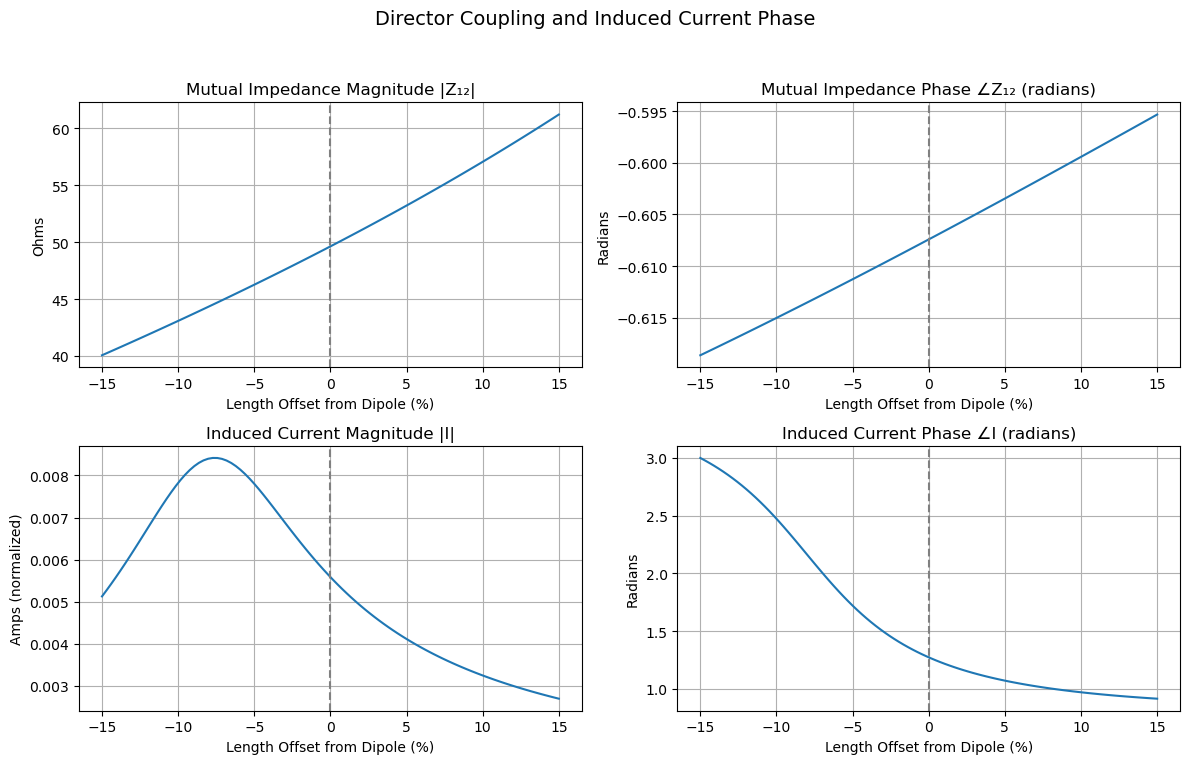

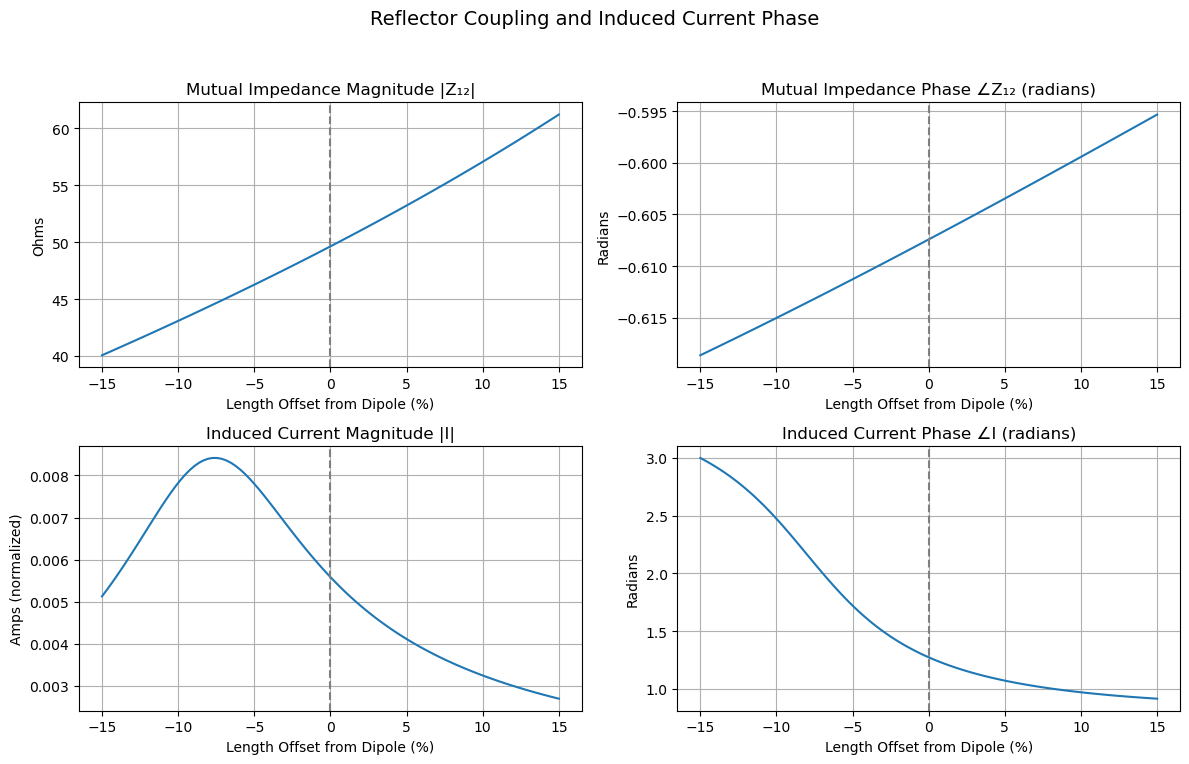

In [41]:
def plot_impedance_current_vs_length_deviation(element_type='director'):
    k = 2 * np.pi
    driven_length = 0.5
    length_offsets = np.linspace(-0.15, 0.15, 100)

    Z_mag, Z_phase = [], []
    I_mag, I_phase = [], []

    for offset in length_offsets:
        if element_type == 'director':
            lengths = [driven_length, driven_length * (1 + offset)]  # [driven, director]
            positions = [(0, 0), (0.25, 0)]  # director in front
            target_index = 1
        else:
            lengths = [driven_length, driven_length * (1 + offset)]  # [driven, reflector]
            positions = [(0, 0), (-0.25, 0)]  # reflector behind
            target_index = 1

        L_1 = lengths
        L_2 = [0.001 for _ in lengths]
        L_3 = positions

        Z = np.array([[Z_new(p, q, k, L_1, L_2, L_3) for q in range(2)] for p in range(2)])
        V = [1, 0]
        I = input_current(V, Z)

        Zpq = Z[0, 1]
        I_target = I[target_index]

        Z_mag.append(abs(Zpq))
        Z_phase.append(np.angle(Zpq))       # radians
        I_mag.append(abs(I_target))
        I_phase.append(np.angle(I_target))  # radians

    # Plotting
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    axs[0, 0].plot(length_offsets * 100, Z_mag)
    axs[0, 0].set_title("Mutual Impedance Magnitude |Z₁₂|")
    axs[0, 0].set_ylabel("Ohms")
    axs[0, 0].set_xlabel("Length Offset from Dipole (%)")
    axs[0, 0].axvline(0, color='gray', linestyle='--')
    axs[0, 0].grid(True)

    axs[0, 1].plot(length_offsets * 100, Z_phase)
    axs[0, 1].set_title("Mutual Impedance Phase ∠Z₁₂ (radians)")
    axs[0, 1].set_ylabel("Radians")
    axs[0, 1].set_xlabel("Length Offset from Dipole (%)")
    axs[0, 1].axvline(0, color='gray', linestyle='--')
    axs[0, 1].grid(True)

    axs[1, 0].plot(length_offsets * 100, I_mag)
    axs[1, 0].set_title("Induced Current Magnitude |I|")
    axs[1, 0].set_ylabel("Amps (normalized)")
    axs[1, 0].set_xlabel("Length Offset from Dipole (%)")
    axs[1, 0].axvline(0, color='gray', linestyle='--')
    axs[1, 0].grid(True)

    axs[1, 1].plot(length_offsets * 100, I_phase)
    axs[1, 1].set_title("Induced Current Phase ∠I (radians)")
    axs[1, 1].set_ylabel("Radians")
    axs[1, 1].set_xlabel("Length Offset from Dipole (%)")
    axs[1, 1].axvline(0, color='gray', linestyle='--')
    axs[1, 1].grid(True)

    plt.suptitle(f"{element_type.capitalize()} Coupling and Induced Current Phase", fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Test for both roles
plot_impedance_current_vs_length_deviation('director')
plot_impedance_current_vs_length_deviation('reflector')

In [42]:
optimize_yagi_antenna(3,50,100)

Démarrage de l'optimisation...
Génération 0/100 - Meilleure: 5.25, Moyenne: 3.55, Temps écoulé: 1.2s


KeyboardInterrupt: 